# Compute the amplitude of B from total-field anomaly data

This code illustrates how to compute the amplitude of the anomalous magnetic field (B) from total-field anomalies.

### Things we have to import

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from gravmag.models import rectangular_prism as rp
from gravmag import plot_functions as plf

In [3]:
from gravmag import filters, convolve, transforms, eqlayer

### Model

In [4]:
# Create a model formed by prisms
model = np.array([[2000., 3000., -1500., -500., 10., 1010.], 
                  [1600., 2600., -2500., -1500., 10., 1010.], 
                  [-1000., 1000., 1500, 2500, 10., 1010.],
                  [-3000., -2000., 1000, 3500., 10., 1010.]])

# magnetization of each prism
# first, second and third columns contain
# the magnetization intensity (in A/m), inclination 
# and declination (in degrees) of the sources
inc, dec = -23.8, -45
magnetization = np.array([[1.4, inc, dec],
                          [1.3, inc, dec],
                          [1.1, inc, dec],
                          [1.2, inc, dec]])

# magnetization used to compute the true RTP of each prism
# first, second and third columns contain
# the magnetization intensity (in A/m), inclination 
# and declination (in degrees) of the sources
magnetization_vertical = np.array([[1.4, 90, 0],
                                   [1.3, 90, 0],
                                   [1.1, 90, 0],
                                   [1.2, 90, 0]])

# Components of the unit vector defining the
# total-magnetization direction
cos_inc = np.cos(np.deg2rad(inc))
sin_inc = np.sin(np.deg2rad(inc))
cos_dec = np.cos(np.deg2rad(dec))
sin_dec = np.sin(np.deg2rad(dec))
hx_hat = cos_inc*cos_dec
hy_hat = cos_inc*sin_dec
hz_hat = sin_inc

### Points were we compute the synthetic data

In [5]:
# number of points along x and y
shape = (60, 60)

# minimum x, maximum x, minimum y and maximum y
area = [-5000, 5000, -4000, 6000]

# Grid spacing
dx = (area[1] - area[0])/(shape[0]-1)
dy = (area[3] - area[2])/(shape[1]-1)

# coordinates 
xp = np.linspace(area[0], area[1], shape[0])
yp = np.linspace(area[2], area[3], shape[1])
yp, xp = np.meshgrid(yp, xp)
yp = np.ravel(yp)
xp = np.ravel(xp)
zp = np.zeros_like(yp) - 150

coordinates = np.vstack([xp, yp, zp])

In [6]:
print(dx, dy)

169.4915254237288 169.4915254237288


### Main field

The cell below defines a spatially variable main field. The inclination, delination and intensity are defined by polynomials.

In [7]:
# reference point
yc, xc = 0, 1000

# inclination (degrees)
I0 = 3 - 1e-4*(xp-xc) + 3e-4*(yp-yc) + 1e-8*(xp-xc)*(xp-xc) + 1e-8*(yp-yc)*(yp-yc)

# declination (degrees)
D0 = 45 + 6e-5*(xp-xc) + 1e-4*(yp-yc) + 3e-9*(xp-xc)*(xp-xc) + 4e-9*(yp-yc)*(yp-yc)

# intensity (nT)
F0 = 23400 + 1e-4*(xp-xc) + 1e-4*(yp-yc) + 0*(xp-xc)*(xp-xc) + 0*(yp-yc)*(yp-yc)

# Cartesian components of the main field
cosI0 = np.cos(np.deg2rad(I0))
sinI0 = np.sin(np.deg2rad(I0))
cosD0 = np.cos(np.deg2rad(D0))
sinD0 = np.sin(np.deg2rad(D0))
Fx = F0*cosI0*cosD0
Fy = F0*cosI0*sinD0
Fz = F0*sinI0

In [8]:
# Compute the average main field
mean_I0 = np.mean(I0)
mean_D0 = np.mean(D0)
cos_mean_I0 = np.cos(np.deg2rad(mean_I0))
sin_mean_I0 = np.sin(np.deg2rad(mean_I0))
cos_mean_D0 = np.cos(np.deg2rad(mean_D0))
sin_mean_D0 = np.sin(np.deg2rad(mean_D0))
Fx_hat = cos_mean_I0*cos_mean_D0
Fy_hat = cos_mean_I0*sin_mean_D0
Fz_hat = sin_mean_I0

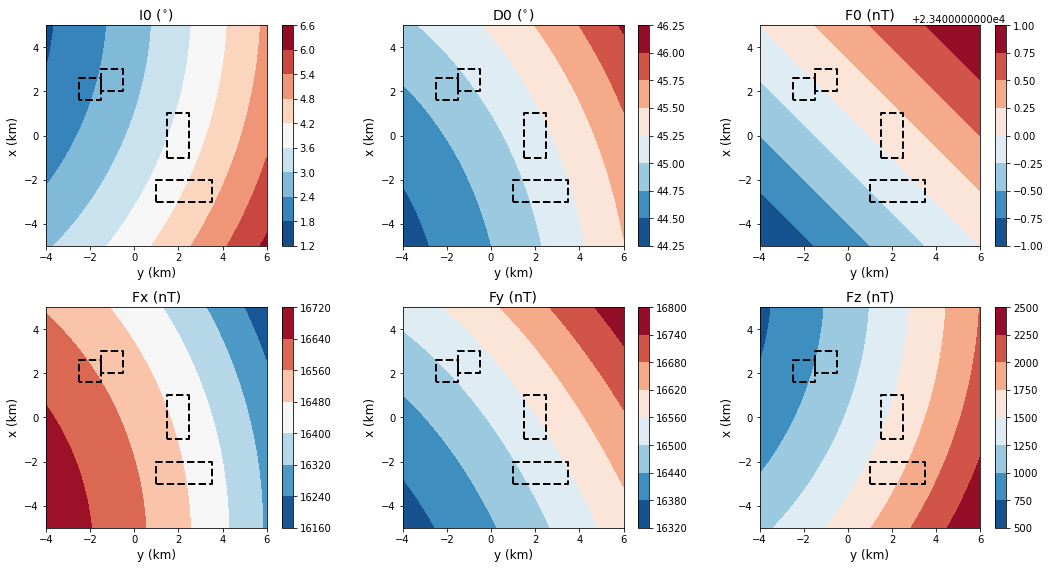

In [9]:
fields = [I0, D0, F0, Fx, Fy, Fz]
windows = [1, 2, 3, 4, 5, 6]
titles = ['I0 ($^{\circ}$)', 'D0 ($^{\circ}$)', 'F0 (nT)',
          'Fx (nT)', 'Fy (nT)', 'Fz (nT)']

plt.figure(figsize=(15,8))

for w, window in enumerate(windows):

    plt.subplot(2,3,window)
    plt.title(titles[w], fontsize=14)
    plt.axis('scaled')
    plt.contourf(yp.reshape(shape)*0.001, 
                 xp.reshape(shape)*0.001, 
                 fields[w].reshape(shape), cmap='RdBu_r')
    plt.colorbar()
    plf.model_boundaries(model, m2km=True)
    plt.ylim(0.001*area[0], 0.001*area[1])
    plt.xlim(0.001*area[2], 0.001*area[3])
    plt.xlabel('y (km)', fontsize=12)
    plt.ylabel('x (km)', fontsize=12)

plt.tight_layout()

plt.show()

### Synthetic data

In [10]:
# Compute the magnetic field components
bx = rp.mag(coordinates=coordinates, prisms=model, magnetization=magnetization, field='x')
by = rp.mag(coordinates=coordinates, prisms=model, magnetization=magnetization, field='y')
bz = rp.mag(coordinates=coordinates, prisms=model, magnetization=magnetization, field='z')

# Add a noise to the synthetic data
# The noise has a normal distribution, zero mean and standard eviation equal to 5 nT
bx += np.random.normal(loc=0, scale=5, size=bx.size)
by += np.random.normal(loc=0, scale=5, size=by.size)
bz += np.random.normal(loc=0, scale=5, size=bz.size)

In [11]:
# Compute the total-field anomaly without approximation
tfa = np.sqrt((Fx+bx)**2 + (Fy+by)**2 + (Fz+bz)**2) - F0

In [12]:
# Compute the "true" amplitude of B
amplitude_B = np.sqrt(bx**2 + by**2 + bz**2)

### Plot the total-field and true amplitude of B

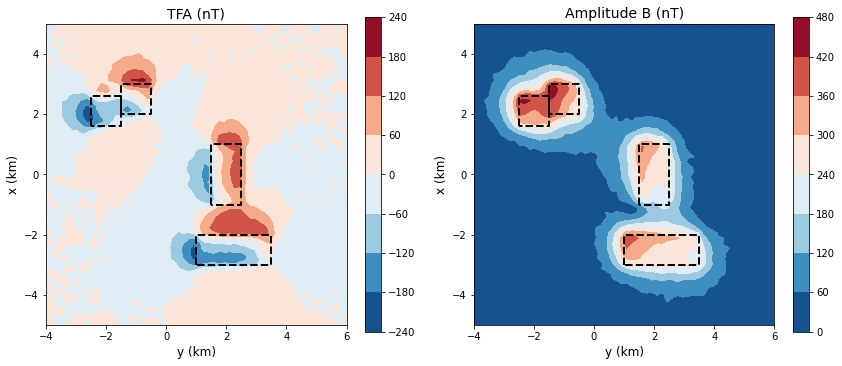

In [13]:
fields = [tfa, amplitude_B]
windows = [1, 2]
titles = ['TFA (nT)', 'Amplitude B (nT)']

plt.figure(figsize=(12,5))

for w, window in enumerate(windows):

    plt.subplot(1,2,window)
    plt.title(titles[w], fontsize=14)
    plt.axis('scaled')
    plt.contourf(yp.reshape(shape)*0.001, 
                 xp.reshape(shape)*0.001, 
                 fields[w].reshape(shape), cmap='RdBu_r')
    plt.colorbar()
    plf.model_boundaries(model, m2km=True)
    plt.ylim(0.001*area[0], 0.001*area[1])
    plt.xlim(0.001*area[2], 0.001*area[3])
    plt.xlabel('y (km)', fontsize=12)
    plt.ylabel('x (km)', fontsize=12)

plt.tight_layout()

plt.show()

### Estimate the amplitude of B via FFT

In [14]:
# 2D Fourier transform of the TFA
F_tfa = transforms.DFT(data=tfa.reshape(shape), pad_mode='linear_ramp')

# compute the wavenumbers
kx, ky, kz = transforms.wavenumbers(F_tfa.shape, dx, dy)

# compute the filter defining the average main field direction in Fourier domain
main_field_filter = filters.direction(kx, ky, kz, mean_I0, mean_D0)

# main_field_filter[0,0] is zero and it causes a division-by-zero problem. 
# Because of that, we set main_field_filter[0,0] equal to 1
main_field_filter[0, 0] = 1.0

# compute the bx, by and bz components in Fourier 
FT_bx_tfa_fourier = convolve.compute(
    FT_data=F_tfa, 
    filters=[1./main_field_filter, 1j*kx]
)
FT_by_tfa_fourier = convolve.compute(
    FT_data=F_tfa, 
    filters=[1./main_field_filter, 1j*ky]
)
FT_bz_tfa_fourier = convolve.compute(
    FT_data=F_tfa, 
    filters=[1./main_field_filter, kz]
)

# 2D Inverse Fourier transform of the field components
bx_tfa_fourier = transforms.IDFT(FT_data=FT_bx_tfa_fourier, unpad=True, grid=False)
by_tfa_fourier = transforms.IDFT(FT_data=FT_by_tfa_fourier, unpad=True, grid=False)
bz_tfa_fourier = transforms.IDFT(FT_data=FT_bz_tfa_fourier, unpad=True, grid=False)

In [15]:
# amplitude of B computed via FFT
amplitude_B_fourier = np.sqrt(bx_tfa_fourier**2 + by_tfa_fourier**2 + bz_tfa_fourier**2)

### Estimate the amplitude of B via equivalent-layer technique

In [16]:
# layer z
z_layer = np.max(zp) + 2.5*(0.5*(dx+dy))

In [17]:
# kernel matrix associated with the equivalent layer
G = eqlayer.kernel_matrix_dipoles(
    coordinates, z_layer, inc, dec, field="t", inct=mean_I0, dect=mean_D0
)

In [18]:
# regularization paramater
u0 = 1e-3*np.trace(G.T@G)/G.shape[1]

In [19]:
# estimated equivalent layer
p_estimated = np.linalg.solve(G.T@G + u0*np.identity(G.shape[1]), G.T@tfa)

In [20]:
# total-field anomaly predicted by the estimated equivalent layer
tfa_eql = G@p_estimated

In [21]:
# kernel matrix associated with the Bx
G = eqlayer.kernel_matrix_dipoles(
    coordinates, z_layer, inc, dec, field="x"
)

bx_tfa_eql = G@p_estimated

# kernel matrix associated with the By
G = eqlayer.kernel_matrix_dipoles(
    coordinates, z_layer, inc, dec, field="y"
)

by_tfa_eql = G@p_estimated

# kernel matrix associated with the Bz
G = eqlayer.kernel_matrix_dipoles(
    coordinates, z_layer, inc, dec, field="z"
)

bz_tfa_eql = G@p_estimated

In [22]:
# amplitude of B computed via equivalent layer
amplitude_B_eql = np.sqrt(bx_tfa_eql**2 + by_tfa_eql**2 + bz_tfa_eql**2)

### Plot the results

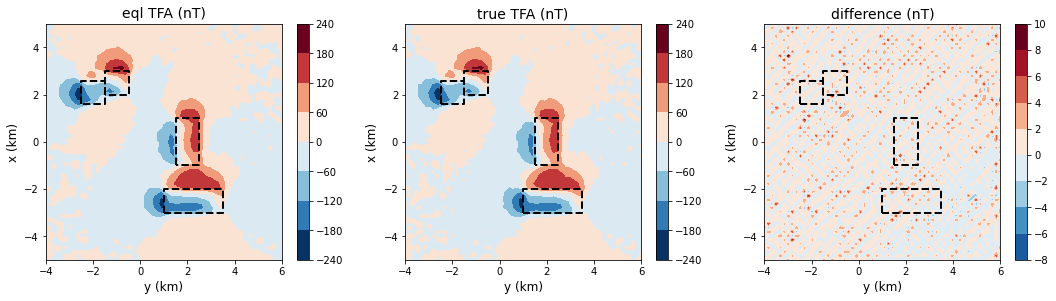

In [23]:
field_names = ['TFA']
field_units =['nT']

true_fields = [tfa]
predicted_fields = [tfa_eql]

bounds, diffs = plf.bounds_diffs(predicted_fields, true_fields)

fields = plf.fields_list(predicted_fields, true_fields, diffs)

titles = []
for name, unit in zip(field_names, field_units):
    titles.append('eql {} ({})'.format(name,unit))
    titles.append('true {} ({})'.format(name,unit))
    titles.append('difference ({})'.format(unit))

windows = [i for i in range(1,4)]

plt.figure(figsize=(15,4))

for w, window in enumerate(windows):

    plt.subplot(1,3,window)
    plt.title(titles[w], fontsize=14)
    plt.axis('scaled')
    plt.contourf(
        yp.reshape(shape)*0.001, 
        xp.reshape(shape)*0.001, 
        fields[w].reshape(shape), 
        cmap='RdBu_r',
        vmin = -bounds[w], vmax = bounds[w]
    )
    plt.colorbar()
    plf.model_boundaries(model, m2km=True)
    plt.ylim(0.001*area[0], 0.001*area[1])
    plt.xlim(0.001*area[2], 0.001*area[3])
    plt.xlabel('y (km)', fontsize=12)
    plt.ylabel('x (km)', fontsize=12)

plt.tight_layout()

plt.show()

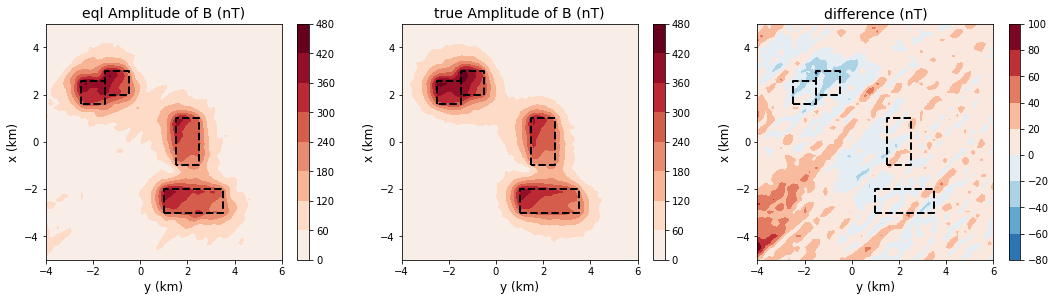

In [24]:
field_names = ['Amplitude of B']
field_units =['nT']

true_fields = [amplitude_B]

predicted_fields = [amplitude_B_eql]

bounds, diffs = plf.bounds_diffs(predicted_fields, true_fields)

fields = plf.fields_list(predicted_fields, true_fields, diffs)

titles = []
for name, unit in zip(field_names, field_units):
    titles.append('eql {} ({})'.format(name,unit))
    titles.append('true {} ({})'.format(name,unit))
    titles.append('difference ({})'.format(unit))

windows = [i for i in range(1,4)]

plt.figure(figsize=(15,4))

for w, window in enumerate(windows):

    plt.subplot(1,3,window)
    plt.title(titles[w], fontsize=14)
    plt.axis('scaled')
    plt.contourf(
        yp.reshape(shape)*0.001, 
        xp.reshape(shape)*0.001, 
        fields[w].reshape(shape), 
        cmap='RdBu_r',
        vmin = -bounds[w], vmax = bounds[w]
    )
    plt.colorbar()
    plf.model_boundaries(model, m2km=True)
    plt.ylim(0.001*area[0], 0.001*area[1])
    plt.xlim(0.001*area[2], 0.001*area[3])
    plt.xlabel('y (km)', fontsize=12)
    plt.ylabel('x (km)', fontsize=12)

plt.tight_layout()

plt.show()

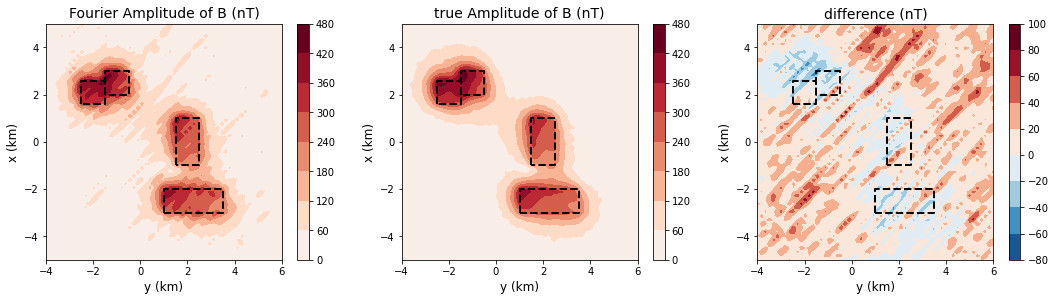

In [25]:
field_names = ['Amplitude of B']
field_units =['nT']

true_fields = [amplitude_B]

predicted_fields = [amplitude_B_fourier]

bounds, diffs = plf.bounds_diffs(predicted_fields, true_fields)

fields = plf.fields_list(predicted_fields, true_fields, diffs)

titles = []
for name, unit in zip(field_names, field_units):
    titles.append('Fourier {} ({})'.format(name,unit))
    titles.append('true {} ({})'.format(name,unit))
    titles.append('difference ({})'.format(unit))

windows = [i for i in range(1,4)]

plt.figure(figsize=(15,4))

for w, window in enumerate(windows):

    plt.subplot(1,3,window)
    plt.title(titles[w], fontsize=14)
    plt.axis('scaled')
    plt.contourf(
        yp.reshape(shape)*0.001, 
        xp.reshape(shape)*0.001, 
        fields[w].reshape(shape), 
        cmap='RdBu_r',
        vmin = -bounds[w], vmax = bounds[w]
    )
    plt.colorbar()
    plf.model_boundaries(model, m2km=True)
    plt.ylim(0.001*area[0], 0.001*area[1])
    plt.xlim(0.001*area[2], 0.001*area[3])
    plt.xlabel('y (km)', fontsize=12)
    plt.ylabel('x (km)', fontsize=12)

plt.tight_layout()

plt.show()